In [1]:
# Model Comparison: Decision Tree vs Neural Network vs Random Forest
# Compare best configurations from each model notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')
from src.config import (
    SEED, DATA_DIR, FIGURES_DIR,
    TARGET_COL, CLAIM_NB_COL, EXPOSURE_COL,
    CATEGORICAL_FEATURES, NUMERICAL_FEATURES, ALL_FEATURES,
    ORDINAL_FEATURES, NOMINAL_FEATURES, AREA_ORDER
)
from src.utils import evaluate_regression, print_metrics
from src.decision_tree import DecisionTreeRegressor
from src.neural_network import NeuralNetwork

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(SEED)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Setup complete. Seed: {SEED}")


Setup complete. Seed: 42


In [2]:
# Load and prepare data
df_train = pd.read_csv(DATA_DIR / 'claims_train.csv')
df_test = pd.read_csv(DATA_DIR / 'claims_test.csv')

# Data cleaning: remove Exposure > 1
df_train = df_train[df_train[EXPOSURE_COL] <= 1].copy()

# Create target: ClaimFrequency = ClaimNb / Exposure
df_train[TARGET_COL] = df_train[CLAIM_NB_COL] / df_train[EXPOSURE_COL]
df_test[TARGET_COL] = df_test[CLAIM_NB_COL] / df_test[EXPOSURE_COL]

# Prepare features and target
X_train_raw = df_train[ALL_FEATURES]
y_train = df_train[TARGET_COL].values
X_test_raw = df_test[ALL_FEATURES]
y_test = df_test[TARGET_COL].values

print(f"Train: {len(X_train_raw):,} samples, Test: {len(X_test_raw):,} samples")
print(f"Target: mean={y_train.mean():.4f}, std={y_train.std():.4f}, max={y_train.max():.1f}")


Train: 541,416 samples, Test: 135,603 samples
Target: mean=0.2616, std=4.4322, max=732.0


In [ ]:
# Preprocessing for each model type
# - Decision Tree (from-scratch): uses raw data, handles categoricals natively
# - Neural Network (from-scratch): needs scaling + encoding
# - Random Forest: needs encoding only (no scaling for trees)

# For Random Forest (encoding only)
preprocessor_rf = ColumnTransformer([
    ('num', 'passthrough', NUMERICAL_FEATURES),
    ('ord', OrdinalEncoder(categories=[AREA_ORDER]), ORDINAL_FEATURES),
    ('nom', OneHotEncoder(drop='first', sparse_output=False), NOMINAL_FEATURES)
])
X_train_rf = preprocessor_rf.fit_transform(X_train_raw)
X_test_rf = preprocessor_rf.transform(X_test_raw)

# For Neural Network (scaling + encoding)
preprocessor_nn = ColumnTransformer([
    ('num', StandardScaler(), NUMERICAL_FEATURES),
    ('ord', OrdinalEncoder(categories=[AREA_ORDER]), ORDINAL_FEATURES),
    ('nom', OneHotEncoder(drop='first', sparse_output=False), NOMINAL_FEATURES)
])
X_train_nn = preprocessor_nn.fit_transform(X_train_raw)
X_test_nn = preprocessor_nn.transform(X_test_raw)

n_features = X_train_nn.shape[1]
print(f"Decision Tree: {X_train_raw.shape[1]} features (raw)")
print(f"Neural Network & Random Forest: {n_features} features (encoded)")


Decision Tree: 9 features (raw)
Neural Network & Random Forest: 38 features (encoded)


In [4]:
# M1: DECISION TREE (from-scratch)
# Best config from 02decision_tree.ipynb: max_depth=10, min_samples_split=100, min_samples_leaf=50
print("M1: DECISION TREE")
print("  Config: max_depth=10, min_samples_split=100, min_samples_leaf=50")

dt = DecisionTreeRegressor(
    max_depth=10, min_samples_split=100, min_samples_leaf=50, random_state=SEED)

start = time.time()
dt.fit(X_train_raw, y_train, feature_names=ALL_FEATURES, categorical_features=CATEGORICAL_FEATURES)
dt_time = time.time() - start

y_train_pred_dt = dt.predict(X_train_raw)
y_test_pred_dt = dt.predict(X_test_raw)

metrics_train_dt = evaluate_regression(y_train, y_train_pred_dt)
metrics_test_dt = evaluate_regression(y_test, y_test_pred_dt)

print(f"  Train: MAE={metrics_train_dt['MAE']:.4f}, RMSE={metrics_train_dt['RMSE']:.4f}, R²={metrics_train_dt['R2']:.6f}")
print(f"  Test:  MAE={metrics_test_dt['MAE']:.4f}, RMSE={metrics_test_dt['RMSE']:.4f}, R²={metrics_test_dt['R2']:.6f}")
print(f"  Time: {dt_time:.1f}s")


M1: DECISION TREE
  Config: max_depth=10, min_samples_split=100, min_samples_leaf=50
Building tree with 541,416 samples and 9 features...
Categorical features: ['Area', 'VehBrand', 'VehGas', 'Region']
Tree built successfully!
  Train: MAE=0.4730, RMSE=4.3720, R²=0.026946
  Test:  MAE=0.4922, RMSE=5.2032, R²=0.000500
  Time: 9.3s


In [5]:
# M2: NEURAL NETWORK (from-scratch)
# Best config from 03neural_network.ipynb: [n_features, 64, 32, 1], lr=0.001, epochs=100
print("M2: NEURAL NETWORK")
print(f"  Config: architecture=[{n_features},64,32,1], lr=0.001, epochs=100")

nn = NeuralNetwork(
    layer_sizes=[n_features, 64, 32, 1], learning_rate=0.001,
    epochs=100, batch_size=128, hidden_activation='relu', random_seed=SEED)

start = time.time()
nn.fit(X_train_nn, y_train, verbose=0)
nn_time = time.time() - start

y_train_pred_nn = nn.predict(X_train_nn)
y_test_pred_nn = nn.predict(X_test_nn)

metrics_train_nn = evaluate_regression(y_train, y_train_pred_nn)
metrics_test_nn = evaluate_regression(y_test, y_test_pred_nn)

print(f"  Train: MAE={metrics_train_nn['MAE']:.4f}, RMSE={metrics_train_nn['RMSE']:.4f}, R²={metrics_train_nn['R2']:.6f}")
print(f"  Test:  MAE={metrics_test_nn['MAE']:.4f}, RMSE={metrics_test_nn['RMSE']:.4f}, R²={metrics_test_nn['R2']:.6f}")
print(f"  Time: {nn_time:.1f}s")


M2: NEURAL NETWORK
  Config: architecture=[38,64,32,1], lr=0.001, epochs=100
NEURAL NETWORK INITIALIZED
Architecture: 38 → 64 → 32 → 1
  Input layer:  38 features
  Hidden layer 1: 64 neurons (relu)
  Hidden layer 2: 32 neurons (relu)
  Output layer: 1 neuron(s) (linear)

Hyperparameters:
  Learning rate: 0.001
  Epochs:        100
  Batch size:    128
  Random seed:   42

TRAINING STARTED
Training samples: 541,416
Batch size: 128
Batches per epoch: 4,230
Total epochs: 100

TRAINING COMPLETED
Final loss: 19.359318
Initial loss: 19.638482
Improvement: 0.279163
  Train: MAE=0.4645, RMSE=4.3921, R²=0.018016
  Test:  MAE=0.4806, RMSE=5.1856, R²=0.007258
  Time: 45.2s


In [6]:
# M3: RANDOM FOREST (sklearn)
# Best config from 04random_forest.ipynb: max_depth=15, min_samples_leaf=10, max_features=0.5
print("M3: RANDOM FOREST")
print("  Config: n_estimators=100, max_depth=15, min_samples_split=2, min_samples_leaf=10, max_features=0.5")

rf = RandomForestRegressor(
    n_estimators=100, max_depth=15, min_samples_split=2, min_samples_leaf=10,
    max_features=0.5, random_state=SEED, n_jobs=-1)

start = time.time()
rf.fit(X_train_rf, y_train)
rf_time = time.time() - start

y_train_pred_rf = rf.predict(X_train_rf)
y_test_pred_rf = rf.predict(X_test_rf)

metrics_train_rf = evaluate_regression(y_train, y_train_pred_rf)
metrics_test_rf = evaluate_regression(y_test, y_test_pred_rf)

print(f"  Train: MAE={metrics_train_rf['MAE']:.4f}, RMSE={metrics_train_rf['RMSE']:.4f}, R²={metrics_train_rf['R2']:.6f}")
print(f"  Test:  MAE={metrics_test_rf['MAE']:.4f}, RMSE={metrics_test_rf['RMSE']:.4f}, R²={metrics_test_rf['R2']:.6f}")
print(f"  Time: {rf_time:.1f}s")


M3: RANDOM FOREST
  Config: n_estimators=100, max_depth=15, min_samples_split=2, min_samples_leaf=10, max_features=0.5
  Train: MAE=0.4599, RMSE=4.2139, R²=0.096075
  Test:  MAE=0.4886, RMSE=5.1751, R²=0.011293
  Time: 17.3s


In [7]:
# COMPARISON TABLE
comparison_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Neural Network', 'Random Forest'],
    'Train_MAE': [metrics_train_dt['MAE'], metrics_train_nn['MAE'], metrics_train_rf['MAE']],
    'Test_MAE': [metrics_test_dt['MAE'], metrics_test_nn['MAE'], metrics_test_rf['MAE']],
    'Train_RMSE': [metrics_train_dt['RMSE'], metrics_train_nn['RMSE'], metrics_train_rf['RMSE']],
    'Test_RMSE': [metrics_test_dt['RMSE'], metrics_test_nn['RMSE'], metrics_test_rf['RMSE']],
    'Train_R2': [metrics_train_dt['R2'], metrics_train_nn['R2'], metrics_train_rf['R2']],
    'Test_R2': [metrics_test_dt['R2'], metrics_test_nn['R2'], metrics_test_rf['R2']],
    'Time_s': [dt_time, nn_time, rf_time]
})

# Generalization gap (train-test)
comparison_df['R2_gap'] = comparison_df['Train_R2'] - comparison_df['Test_R2']

print("MODEL COMPARISON (Test Set)")
print(comparison_df[['Model', 'Test_MAE', 'Test_RMSE', 'Test_R2', 'R2_gap', 'Time_s']].to_string(index=False))

# Best model per metric
best_mae = comparison_df.loc[comparison_df['Test_MAE'].idxmin()]
best_r2 = comparison_df.loc[comparison_df['Test_R2'].idxmax()]
print(f"\nBest by MAE: {best_mae['Model']} (MAE={best_mae['Test_MAE']:.4f})")
print(f"Best by R²:  {best_r2['Model']} (R²={best_r2['Test_R2']:.6f})")


MODEL COMPARISON (Test Set)
         Model  Test_MAE  Test_RMSE  Test_R2   R2_gap    Time_s
 Decision Tree  0.492241   5.203229 0.000500 0.026446  9.264876
Neural Network  0.480554   5.185608 0.007258 0.010759 45.187048
 Random Forest  0.488576   5.175058 0.011293 0.084782 17.295549

Best by MAE: Neural Network (MAE=0.4806)
Best by R²:  Random Forest (R²=0.011293)


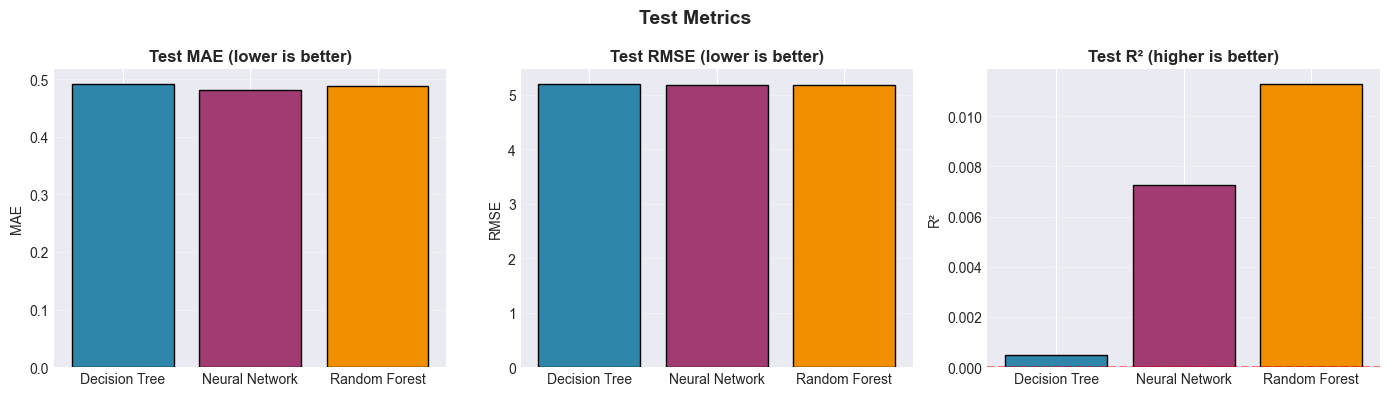

In [15]:
# Test Metrics: MAE, RMSE, R²
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
models = comparison_df['Model'].values
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Test MAE
axes[0].bar(models, comparison_df['Test_MAE'], color=colors, edgecolor='black')
axes[0].set_title('Test MAE (lower is better)', fontweight='bold')
axes[0].set_ylabel('MAE')
axes[0].grid(True, alpha=0.3, axis='y')

# Test RMSE
axes[1].bar(models, comparison_df['Test_RMSE'], color=colors, edgecolor='black')
axes[1].set_title('Test RMSE (lower is better)', fontweight='bold')
axes[1].set_ylabel('RMSE')
axes[1].grid(True, alpha=0.3, axis='y')

# Test R²
axes[2].bar(models, comparison_df['Test_R2'], color=colors, edgecolor='black')
axes[2].set_title('Test R² (higher is better)', fontweight='bold')
axes[2].set_ylabel('R²')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.suptitle('Test Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'models_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


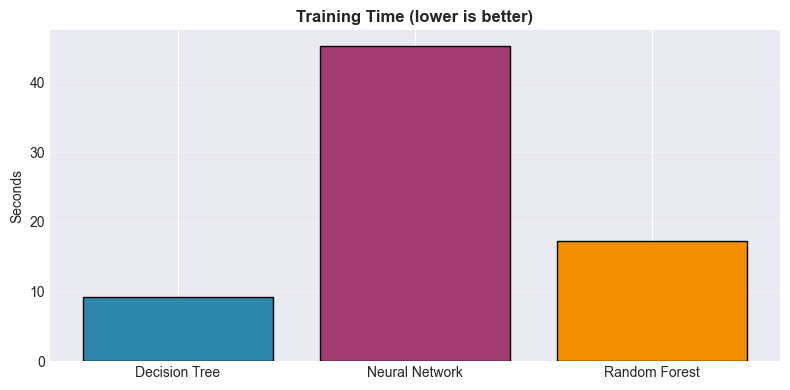

In [16]:
# Training Time
fig, ax = plt.subplots(figsize=(8, 4))
models = comparison_df['Model'].values
colors = ['#2E86AB', '#A23B72', '#F18F01']

ax.bar(models, comparison_df['Time_s'], color=colors, edgecolor='black')
ax.set_title('Training Time (lower is better)', fontweight='bold', fontsize=12)
ax.set_ylabel('Seconds')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


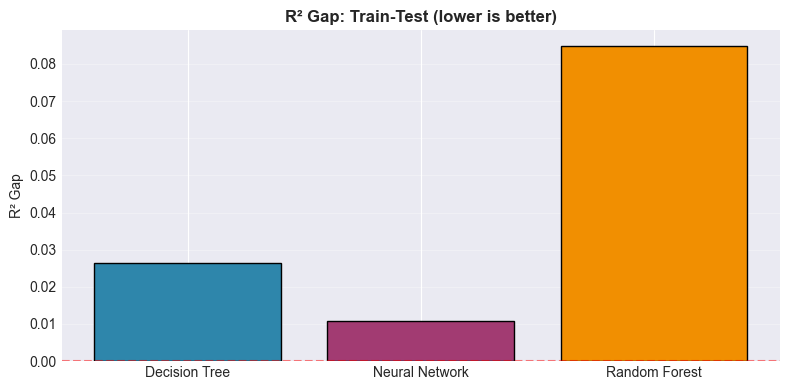

In [17]:
# R² Gap (overfitting indicator)
fig, ax = plt.subplots(figsize=(8, 4))
models = comparison_df['Model'].values
colors = ['#2E86AB', '#A23B72', '#F18F01']

ax.bar(models, comparison_df['R2_gap'], color=colors, edgecolor='black')
ax.set_title('R² Gap: Train-Test (lower is better)', fontweight='bold', fontsize=12)
ax.set_ylabel('R² Gap')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


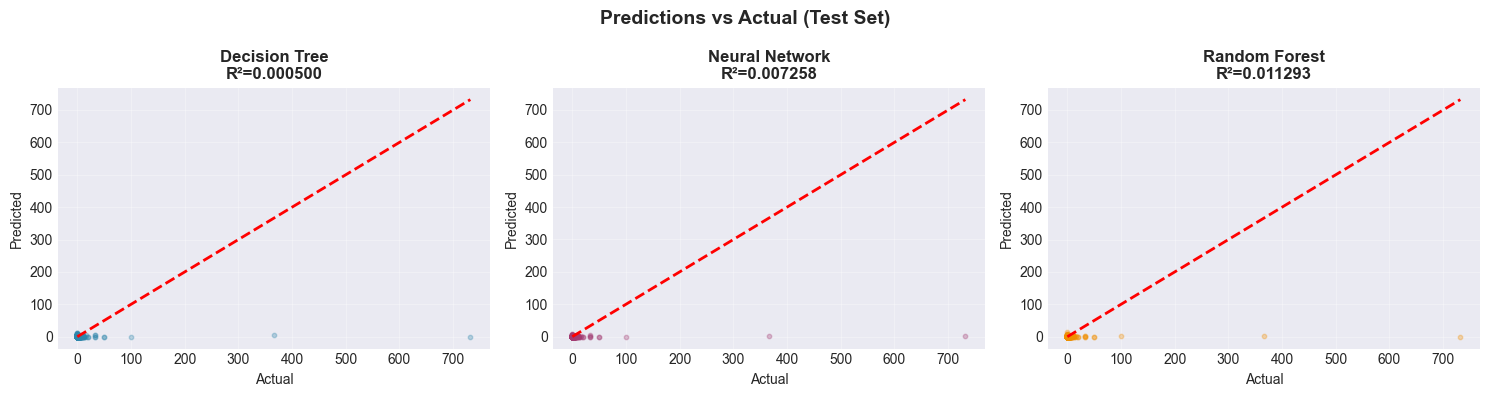

Saved: /Users/matteo/Desktop/TRYG_ML/notebooks/../figures/models_comparison_predictions.png


In [9]:
# VISUALIZATION: Predictions vs Actual (test set)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Subsample for clarity
sample_size = min(5000, len(y_test))
idx = np.random.choice(len(y_test), sample_size, replace=False)
y_sample = y_test[idx]

predictions = [
    ('Decision Tree', y_test_pred_dt[idx], metrics_test_dt, '#2E86AB'),
    ('Neural Network', y_test_pred_nn[idx], metrics_test_nn, '#A23B72'),
    ('Random Forest', y_test_pred_rf[idx], metrics_test_rf, '#F18F01')
]

for ax, (name, y_pred, metrics, color) in zip(axes, predictions):
    ax.scatter(y_sample, y_pred, alpha=0.3, s=10, color=color)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f"{name}\nR²={metrics['R2']:.6f}", fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Predictions vs Actual (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'models_comparison_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'models_comparison_predictions.png'}")


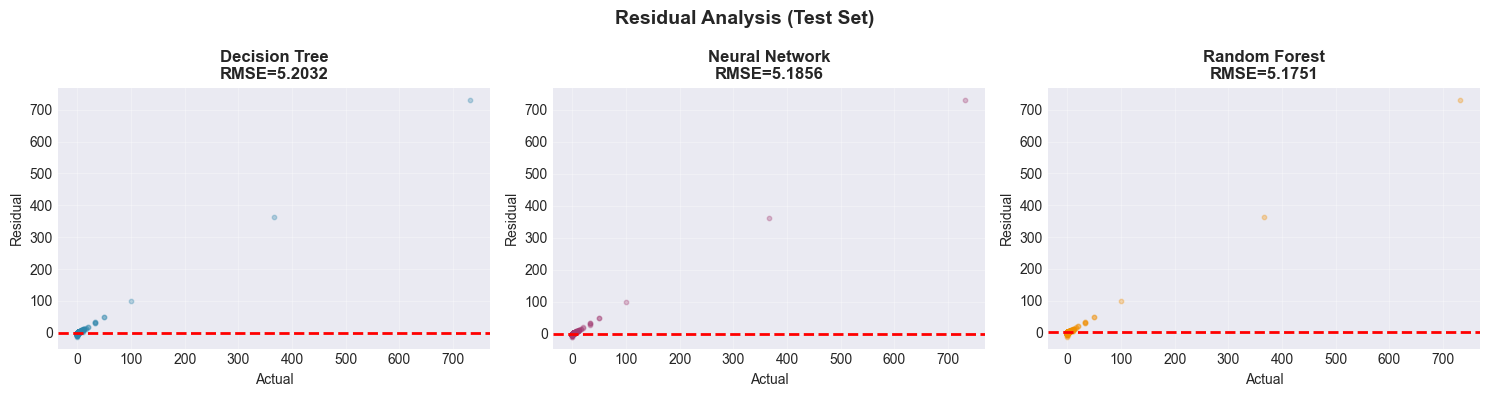

Saved: /Users/matteo/Desktop/TRYG_ML/notebooks/../figures/models_comparison_residuals.png


In [10]:
# VISUALIZATION: Residual analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

residuals = [
    ('Decision Tree', y_sample - y_test_pred_dt[idx], metrics_test_dt, '#2E86AB'),
    ('Neural Network', y_sample - y_test_pred_nn[idx], metrics_test_nn, '#A23B72'),
    ('Random Forest', y_sample - y_test_pred_rf[idx], metrics_test_rf, '#F18F01')
]

for ax, (name, resid, metrics, color) in zip(axes, residuals):
    ax.scatter(y_sample, resid, alpha=0.3, s=10, color=color)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Residual')
    ax.set_title(f"{name}\nRMSE={metrics['RMSE']:.4f}", fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Residual Analysis (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'models_comparison_residuals.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'models_comparison_residuals.png'}")


In [12]:
# FINAL SUMMARY

print("FINAL SUMMARY")

# Ranking by test MAE (primary metric)
print("\nRanking by Test MAE (lower is better):")
for i, row in enumerate(comparison_df.sort_values('Test_MAE').itertuples(), 1):
    print(f"  {i}. {row.Model:15s} MAE={row.Test_MAE:.4f}, RMSE={row.Test_RMSE:.4f}, R²={row.Test_R2:.6f}")

# Model configurations
print("\nModel Configurations:")
print("  Decision Tree:  max_depth=10, min_samples_split=100, min_samples_leaf=50")
print(f"  Neural Network: arch=[{n_features},64,32,1], lr=0.001, epochs=100")
print("  Random Forest:  n_estimators=100, max_depth=15, leaf=10, max_features=0.5")

# Overfitting analysis
print("\nOverfitting (R² gap train-test):")
for row in comparison_df.itertuples():
    status = "Low" if abs(row.R2_gap) < 0.02 else "Moderate" if abs(row.R2_gap) < 0.05 else "High"
    print(f"  {row.Model:15s} gap={row.R2_gap:.6f} [{status}]")

# Conclusion
best = comparison_df.loc[comparison_df['Test_MAE'].idxmin()]
print(f"\nBest model: {best['Model']}")
print(f"  Test MAE:  {best['Test_MAE']:.4f}")
print(f"  Test RMSE: {best['Test_RMSE']:.4f}")
print(f"  Test R²:   {best['Test_R2']:.6f}")

# Note on low R² values
# Note: All models show low R² (~0.01) due to:")
# Highly sparse target (most claims = 0)")
# Extreme outliers (max=732 vs mean=0.26)")
# Zero-inflated distribution")




FINAL SUMMARY

Ranking by Test MAE (lower is better):
  1. Neural Network  MAE=0.4806, RMSE=5.1856, R²=0.007258
  2. Random Forest   MAE=0.4886, RMSE=5.1751, R²=0.011293
  3. Decision Tree   MAE=0.4922, RMSE=5.2032, R²=0.000500

Model Configurations:
  Decision Tree:  max_depth=10, min_samples_split=100, min_samples_leaf=50
  Neural Network: arch=[38,64,32,1], lr=0.001, epochs=100
  Random Forest:  n_estimators=100, max_depth=15, leaf=10, max_features=0.5

Overfitting (R² gap train-test):
  Decision Tree   gap=0.026446 [Moderate]
  Neural Network  gap=0.010759 [Low]
  Random Forest   gap=0.084782 [High]

Best model: Neural Network
  Test MAE:  0.4806
  Test RMSE: 5.1856
  Test R²:   0.007258
